<a href="https://colab.research.google.com/github/Sakiba1705/CLIP-Vision-Transformer-Approach-Melanoma-Detection/blob/main/Melanoma_detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

#Load libraries

In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

Checking for device

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakibaakter1911359","key":"4be5d3cb6a8cc5171ec15f15bc79430d"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d drscarlat/melanoma

100% 5.26G/5.26G [00:50<00:00, 153MB/s]
100% 5.26G/5.26G [00:50<00:00, 112MB/s]


In [ ]:
! unzip /content/melanoma.zip

Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

#Transforms

In [ ]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

#Path for training and testing directory

In [ ]:
train_path='/content/dermmel/DermMel/train_sep'
test_path='/content/dermmel/DermMel/test'

#Create Dataloader

In [ ]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=256, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=256, shuffle=True
)

categories

In [ ]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(classes)

['Melanoma', 'NotMelanoma']


#Build CNN Network

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features= 32*75*75,out_features=num_classes)



    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output



In [ ]:
model=ConvNet(num_classes=2).to(device)

#Optmizer and loss function

In [ ]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

#Calculating the size of training and testing images

In [ ]:
train_count=len(train_loader.dataset)
test_count=len(test_loader.dataset)

In [ ]:
print(train_count,test_count)

10682 3561


In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

#Model training and saving the best model

In [ ]:
best_accuracy=0.0

for epoch in range(num_epochs):

    #Evaluation on training dataset

    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    # Evaluation on testing dataset

    model.eval()

    test_accuracy=0.0
    test_loss = 0.0

    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)

        test_loss += loss.cpu().data * images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy=test_accuracy/test_count
    test_loss = test_loss / test_count
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+ ' Test Loss: ' + str(test_loss)+' Test Accuracy: '+str(test_accuracy))

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy




Epoch: 0 Train Loss: tensor(4.3534) Train Accuracy: 0.7207451788054672 Test Loss: tensor(1.0795) Test Accuracy: 0.7537208649255827
Epoch: 1 Train Loss: tensor(0.9564) Train Accuracy: 0.7897397491106535 Test Loss: tensor(0.8195) Test Accuracy: 0.7747823645043527
Epoch: 2 Train Loss: tensor(1.4248) Train Accuracy: 0.7686762778505898 Test Loss: tensor(1.9193) Test Accuracy: 0.7789946644201067
Epoch: 3 Train Loss: tensor(0.7091) Train Accuracy: 0.8249391499719154 Test Loss: tensor(0.5057) Test Accuracy: 0.7972479640550407
Epoch: 4 Train Loss: tensor(0.4842) Train Accuracy: 0.8533982400299569 Test Loss: tensor(0.3392) Test Accuracy: 0.8413367031732659
Epoch: 5 Train Loss: tensor(0.4634) Train Accuracy: 0.8579853959932597 Test Loss: tensor(0.6292) Test Accuracy: 0.7270429654591407
Epoch: 6 Train Loss: tensor(0.5516) Train Accuracy: 0.8400112338513387 Test Loss: tensor(0.4249) Test Accuracy: 0.7037349059253019
Epoch: 7 Train Loss: tensor(0.6477) Train Accuracy: 0.8584534731323722 Test Loss: t

# Plot the loss and accuracy curves

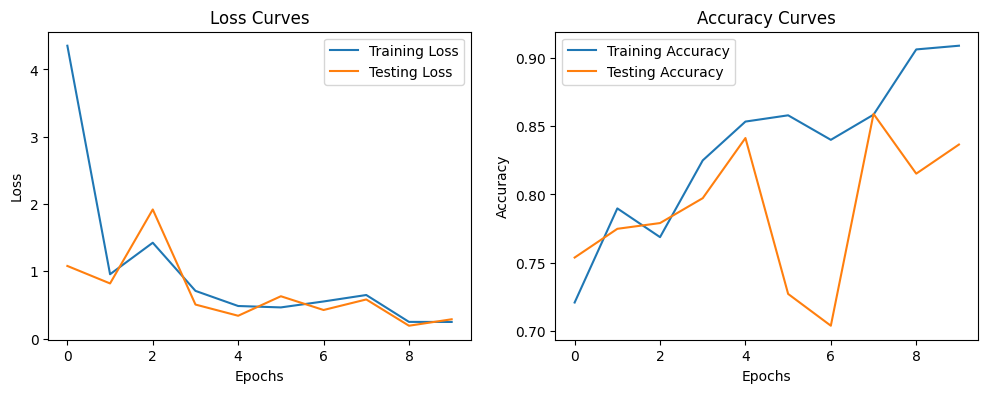

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

# Load the trained model for make prediction

In [ ]:
model = ConvNet(num_classes=2).to(device)
model.load_state_dict(torch.load('best_checkpoint.model'))
model.eval()


ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=2, bias=True)
)

#Preprocess the input image

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transformer(image).unsqueeze(0)  # Add a batch dimension
    return image.to(device)


#Build prediction function

In [ ]:
def predict_image(image_path):

    input_image = preprocess_image(image_path)

    # Make a prediction
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(input_image)
        probabilities = torch.softmax(output, dim=1)  # Get class probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Get the predicted class index

    # Return the predicted class and probabilities
    return predicted_class, probabilities[0]


#Make predictions

In [ ]:
image_path_to_predict = '/content/ISIC_0034258.jpg'
predicted_class, probabilities = predict_image(image_path_to_predict)

print(f'Predicted Class: {classes[predicted_class]}')
print(f'Class Probabilities: {probabilities}')


Predicted Class: NotMelanoma
Class Probabilities: tensor([0.0800, 0.9200], device='cuda:0')
